# Monthly mean house prices in DC by zipcode

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from get_data import *
dc_df_T = get_the_data()
zipcodes = list(dc_df_T.columns)

# dc_df_T.head()

In [3]:
pd.set_option('display.max_columns', 500)
import matplotlib 

import matplotlib.pyplot as plt
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
plt.rcParams['figure.figsize'] = 12, 6

In [4]:
# check for NA
# dc_df_T.plot()

# Can we predict housing prices?

In [5]:
from all_the_functions import *

Start with one zipcode: 20002

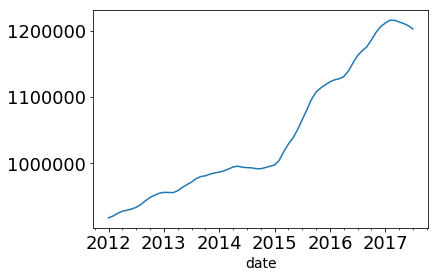

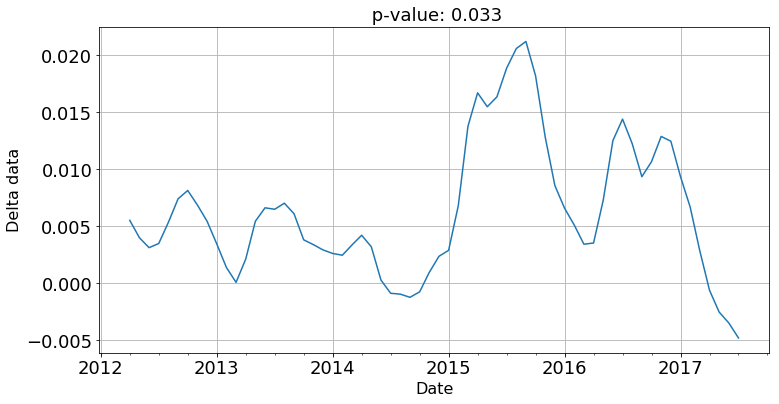

In [6]:
data = dc_df_T.loc['2012-01-01':'2017-07-1'][20016]


data.plot()
Trend_elimination(data)
ldata = np.log(data)
data_roll_mean = ldata.shift(12)
# ldata = np.log(data.)
# pval = Compare_Transformations(ldata, ldata.shift(1))

Plot_Compare(ldata, ldata.rolling(window=4).mean())

# decomposition = sm.tsa.seasonal_decompose(data, model='additive')
# fig = decomposition.plot()
# data.head(),ldata.head()

Now apply to all the zipcodes

In [8]:
results = []
train_data = []
test_data =[]
pdq_params = []
seasonal_pdq_params = []

for zipcode in zipcodes:
    time_start = '2012'
    time_cut = '2017-07'
    y = dc_df_T[zipcode].resample('MS').mean()
    y_train = y[time_start:time_cut]

    y_test = y[time_cut:]
    y_test = y_test[1:]
    
    # make it stationary
    name, pvalue, ybest_data = Trend_elimination(y_train)    
    print("{} The best data is the '{}' data set \npvalue:{}".format(zipcode, name, pvalue))
    
    # Get the Parameters on the difference between y and ybest
    y_diff = y_train - ybest_data
    y_diff.dropna(inplace=True)
    p_params = Get_p_params(y_diff)
    q_params = Get_q_params(y_diff)
#     print(p_params, q_params, '    ')
#     # Fit the MODEL
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        model, best_order, best_seasonal_order = Get_Best_Model(y_train,
                                                        p_params,
                                                        q_params)
    
        result = model.fit()
        results.append(result)
        train_data.append(y_train)
        test_data.append(y_test)
        pdq_params.append(best_order)
        seasonal_pdq_params.append(best_seasonal_order)

20002 The best data is the 'rolling_mean_data' data set 
pvalue:0.03039488062411294
................................................................-
................................................................-
................................................................-
................................................................-
................................................................-
....20009 The best data is the 'diff_data_12' data set 
pvalue:1.6828979089714616e-05
................................................................-
................................................................-
................................................................-
................................................................-
................................................................-
....20011 The best data is the 'diff_data_12' data set 
pvalue:0.011673803660303456
................................................................-
....................

In [9]:
import pickle
PIK = "zillow_fits.pkl"


with open(PIK, "wb") as f:
    for res in results:
#         print(res)
        pickle.dump(res, f)
    for pdq in pdq_params:
        pickle.dump(pdq, f)
    for spdq in seasonal_pdq_params:
        pickle.dump(spdq,f)

In [10]:
from sklearn import metrics

profit = []
percent = []
for model in results:
    pred = model.get_prediction(start=pd.to_datetime('2018-04'),
                              end=pd.to_datetime('2019-04'),
                             dynamic=True)
    profit.append(pred.predicted_mean[-1] - pred.predicted_mean[0])
    percent.append(pred.predicted_mean[-1]/pred.predicted_mean[0]-1)
    
root_mean = []
r2 = []
for model in results:
    pred = model.get_prediction(start=pd.to_datetime('2017-08-01'),
                              end=pd.to_datetime('2018-04-01'),
                             dynamic=True)
    root_mean.append(np.sqrt(metrics.mean_squared_error(test_data[0], pred.predicted_mean)))
    r2.append(metrics.r2_score(test_data[0], pred.predicted_mean))

In [10]:
df_profits = pd.DataFrame({'zipcode': zipcodes, 'profit': profit, 'percent': percent, 'rmse': root_mean, 'r2': r2})
df_profits

,zipcode,profit,percent,rmse,r2
0,20002,52578.952370,0.074835,7997.954723,-0.238976
1,20009,54510.478183,0.052336,353078.345791,-2413.611756
2,20011,43262.480892,0.071762,83766.439101,-134.908072
3,20019,54960.905226,0.168047,369520.425268,-2643.734268
4,20001,66993.947883,0.084216,100970.478436,-196.466747
5,20020,20610.644515,0.062316,354784.577101,-2437.005095
6,20008,162329.736240,0.111559,788645.745707,-12045.727154
7,20003,33135.459910,0.039401,144746.159613,-404.806729
8,20032,35621.293248,0.123676,385040.756408,-2870.564317
9,20016,79440.168135,0.064520,524735.248440,-5332.172378


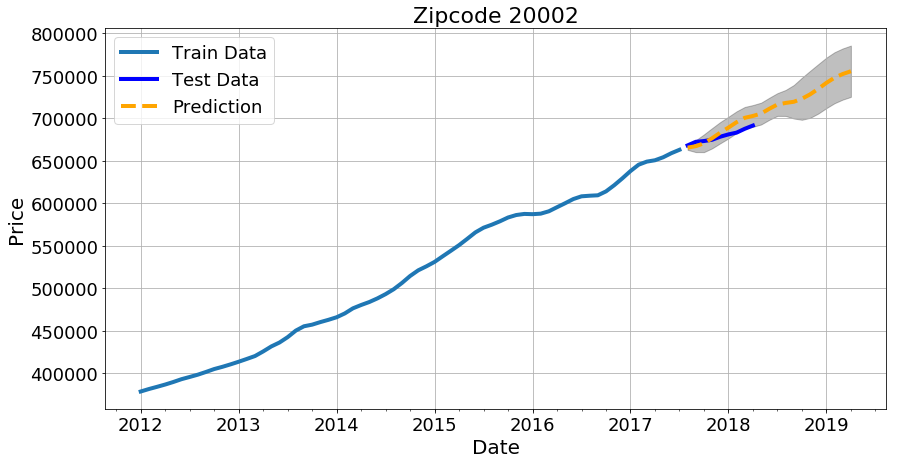

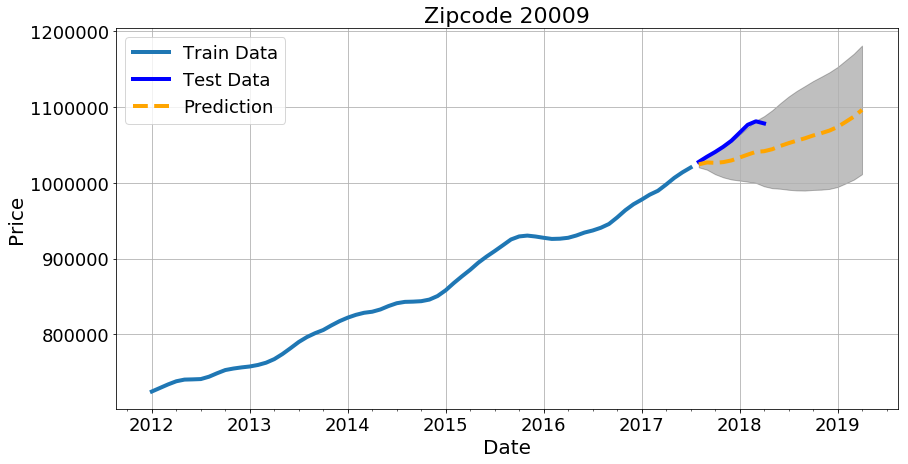

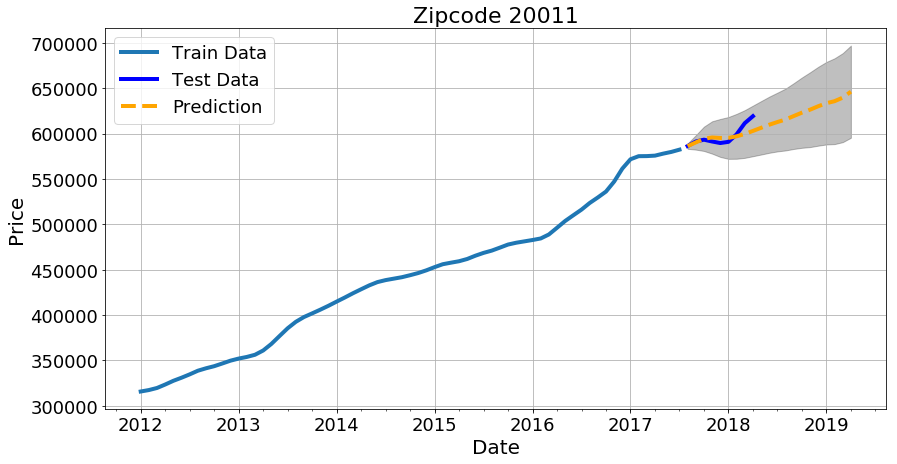

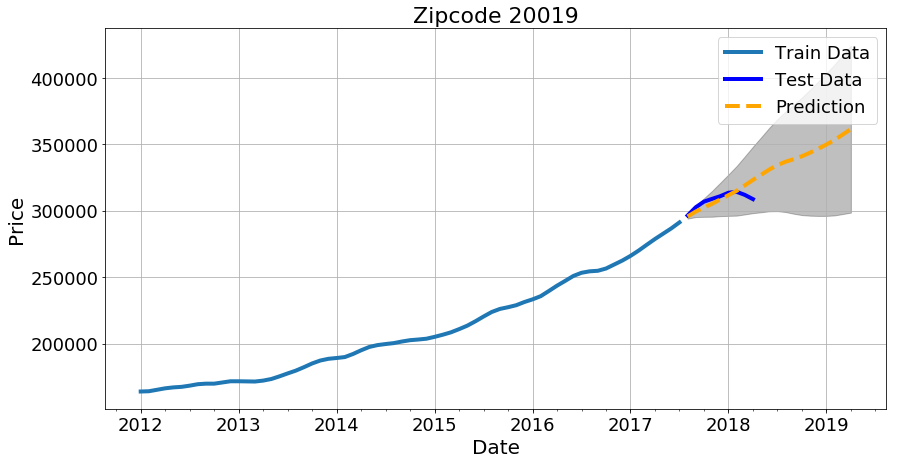

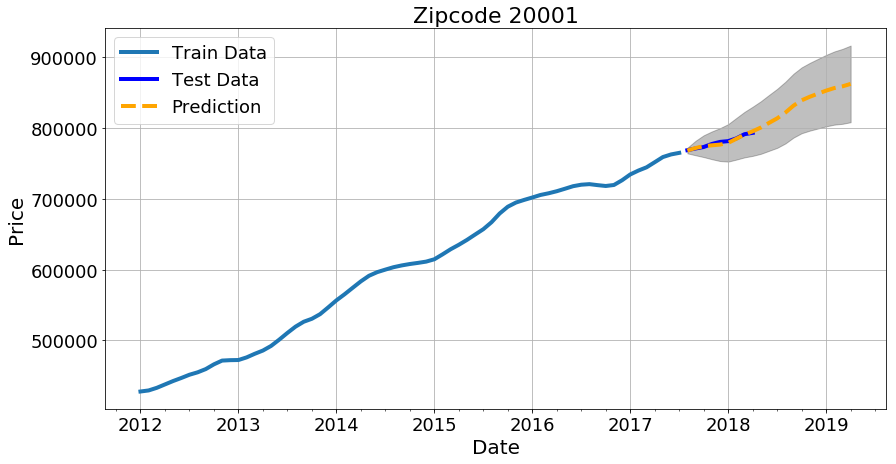

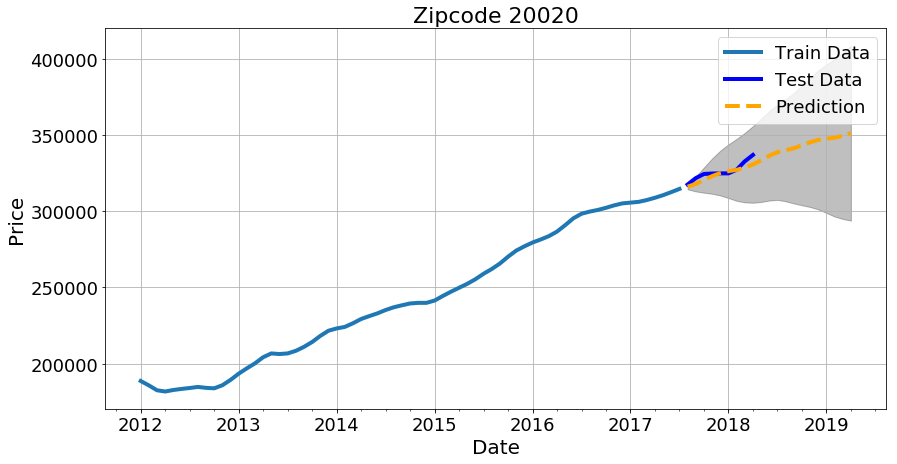

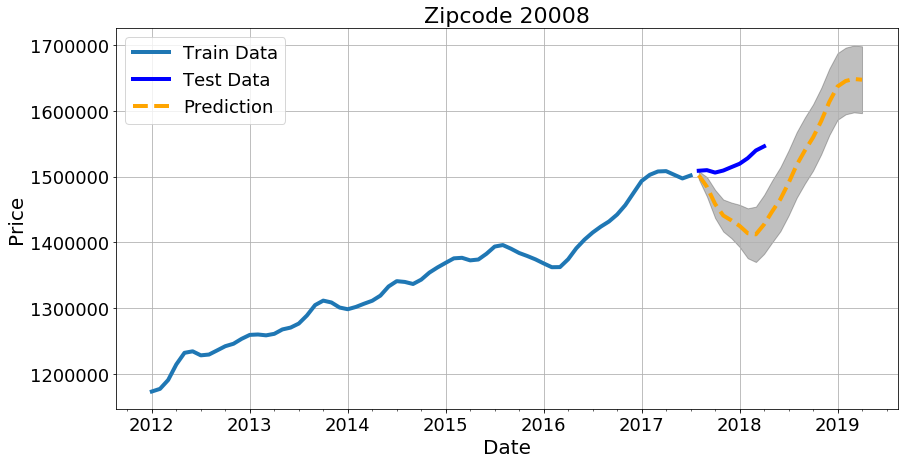

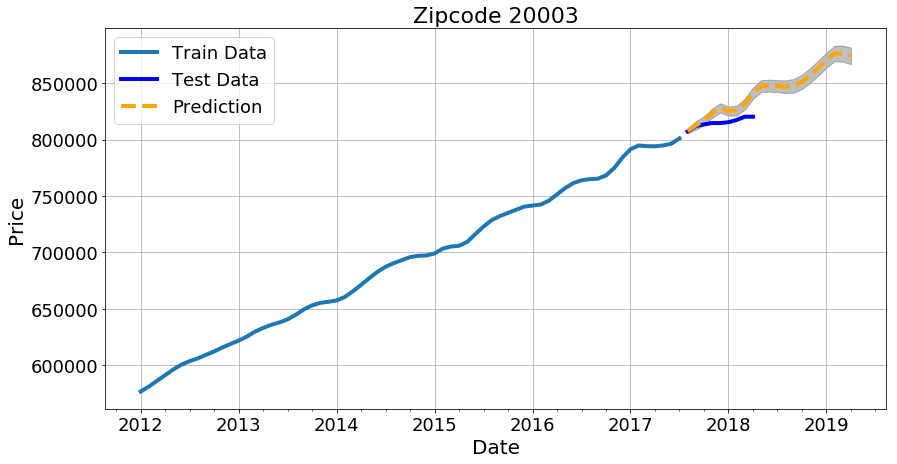

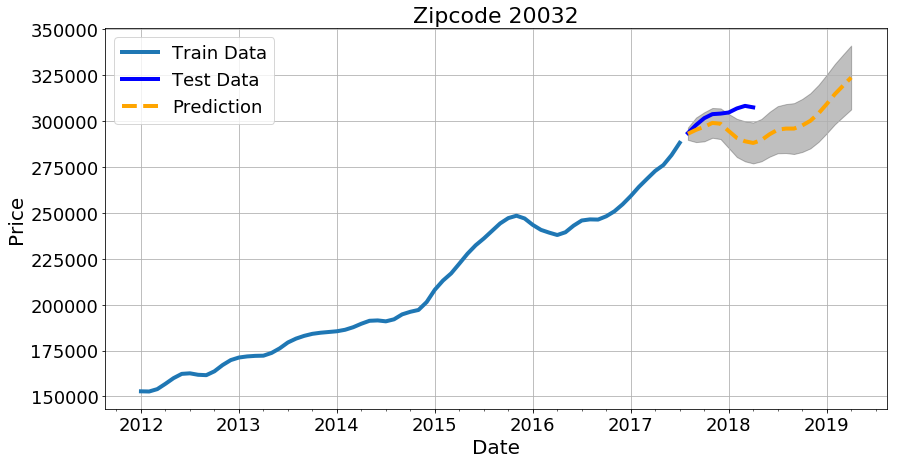

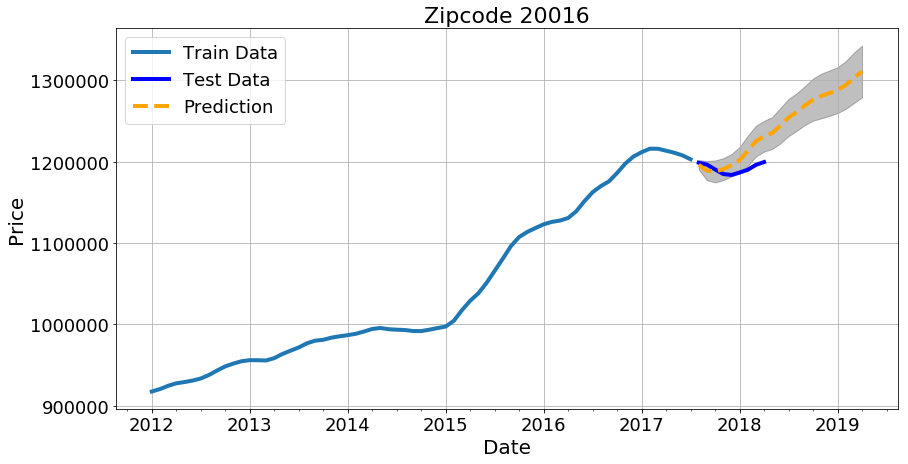

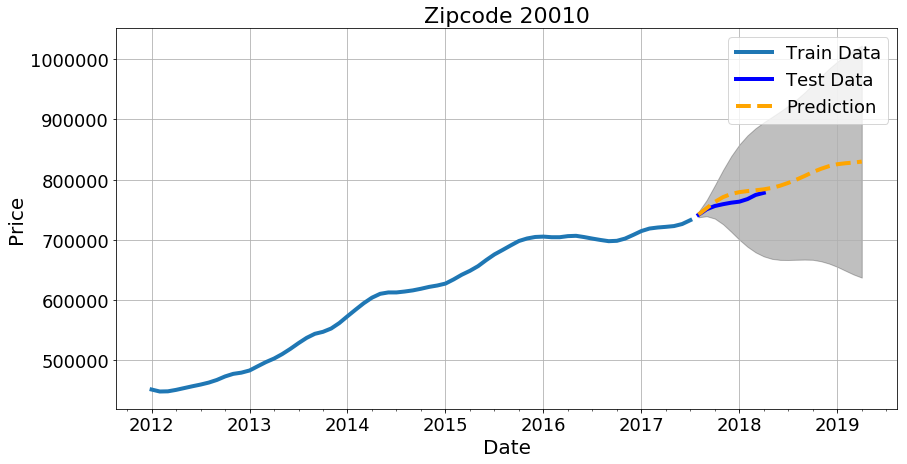

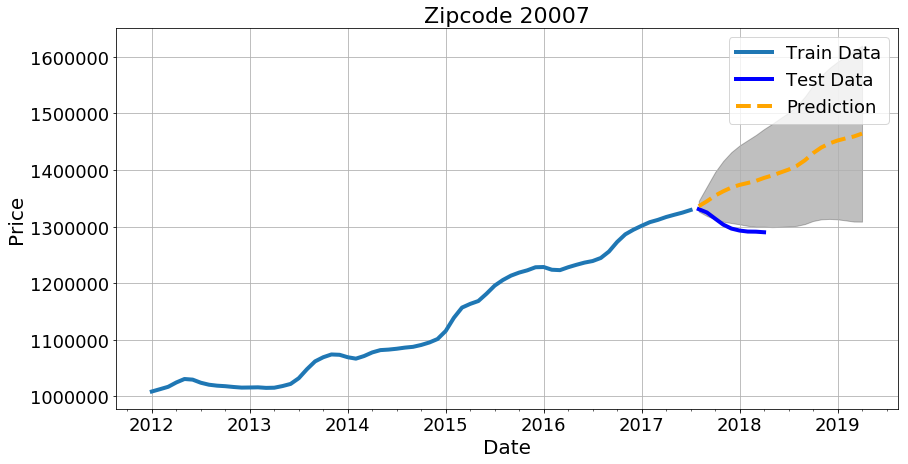

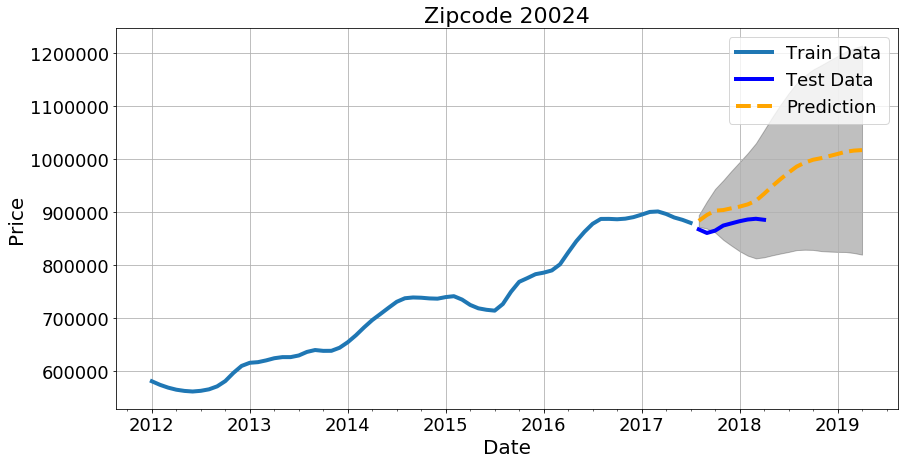

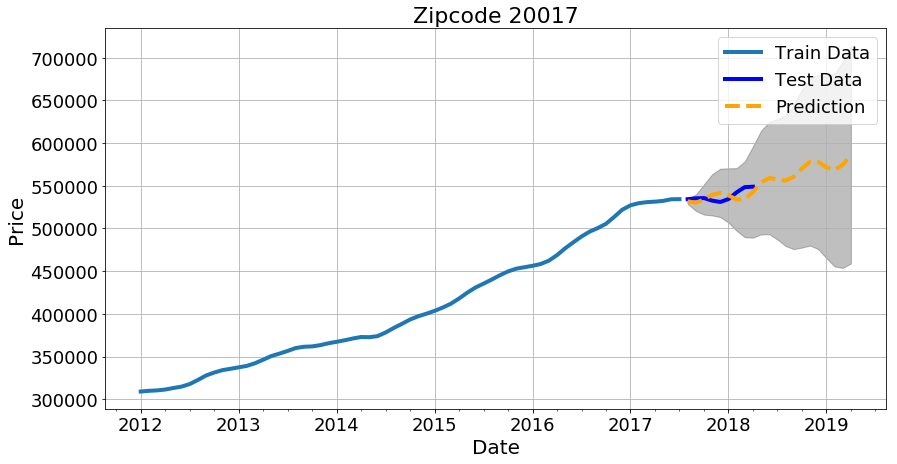

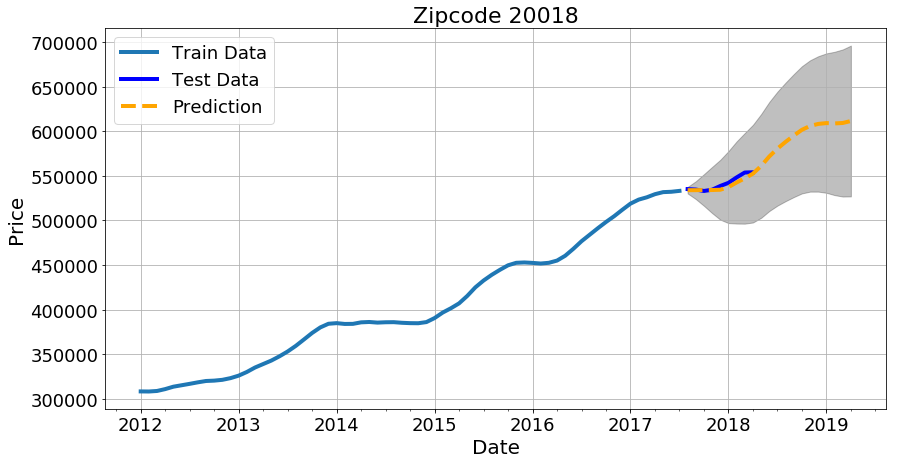

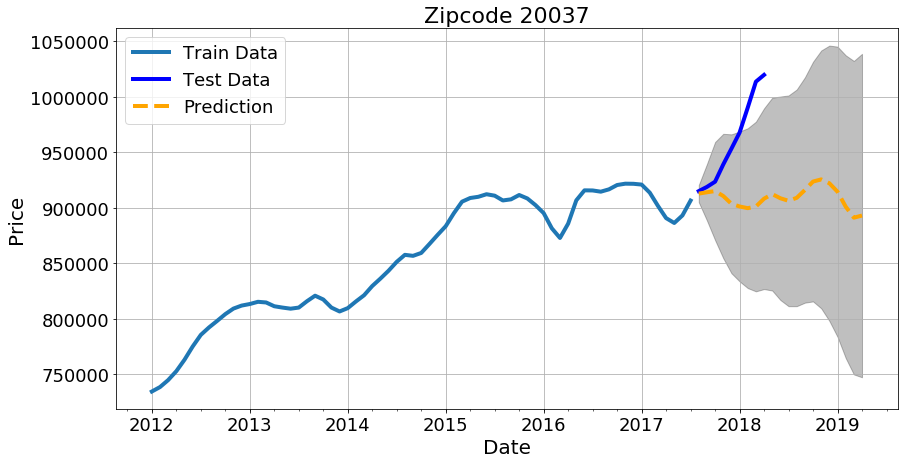

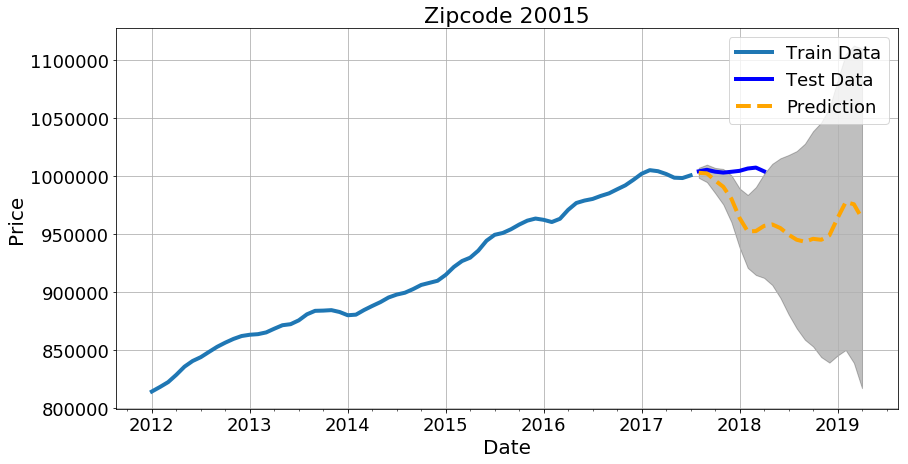

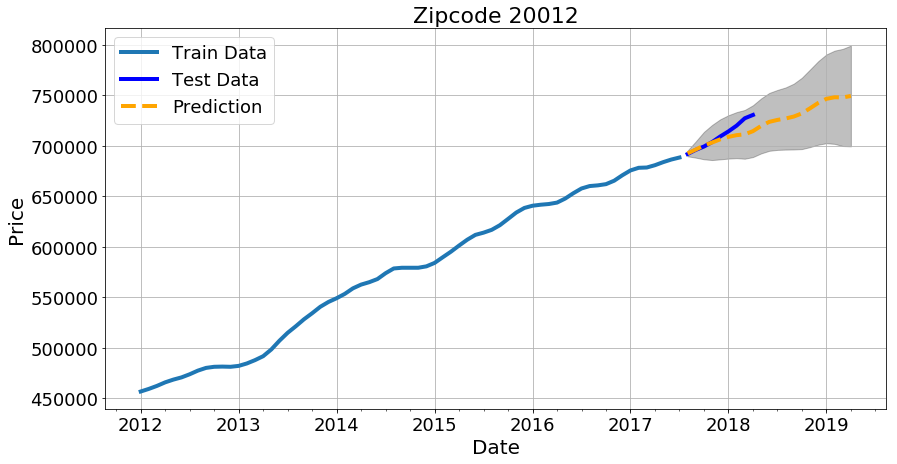

In [11]:
for i, val in enumerate(zipcodes):
    Make_PredictionPlot(results[i], train_data[i], test_data[i], 
                        val, time_cut, print_test=True)

In [12]:
from sklearn import metrics

root_mean = []
r2 = []
for i,model in enumerate(results):
    pred = model.get_prediction(start=(pd.to_datetime(time_cut) + pd.DateOffset(months=1)),
                              end=pd.to_datetime('2018-04-01'),
                             dynamic=True)
    root_mean.append(np.sqrt(metrics.mean_squared_error(test_data[i], pred.predicted_mean)))
    r2.append(metrics.r2_score(test_data[i], pred.predicted_mean))
# print(pred)
# print(root_mean)
# print(r2)

(-10, 2)

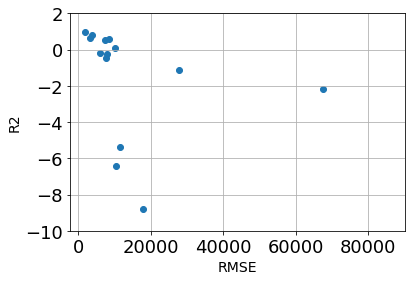

In [13]:
plt.scatter(root_mean, r2)
plt.grid(True)
plt.xlabel('RMSE')
plt.ylabel('R2')
plt.ylim(-10,2)

In [14]:
best_zipcodes=[]
for i,model in enumerate(results):
    if(r2[i]>-2 and root_mean[i]<10000):
        print(zipcodes[i])

20002
20011
20019
20001
20020
20017
20018
20012


In [15]:
final_zipcodes = []
final_results = []
final_train_data = []
final_test_data =[]
final_pdq_params = []
final_seasonal_pdq_params = []
time_start = '2012'
time_cut = '2018-04'


for i,model in enumerate(results):
    if(r2[i]>-2 and root_mean[i]<10000):  

        zipcode = zipcodes[i]
        final_zipcodes.append(zipcode)
        y = dc_df_T[zipcode].resample('MS').mean()
        y_train = y[time_start:time_cut]

        y_test = y[time_cut:]
        y_test = y_test[1:]
    

        p_params = pdq_params[i]
        q_params = seasonal_pdq_params[i]
    
        # Fit the MODEL with the best parameters
        print(q_params)
        model = sm.tsa.statespace.SARIMAX(y_train,
                                        order=p_params,
                                        seasonal_order=q_params,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        result = model.fit()
        final_results.append(result)
        final_train_data.append(y_train)
        final_test_data.append(y_test)
        final_pdq_params.append(best_order)
        final_seasonal_pdq_params.append(best_seasonal_order)

(2, 1, 1, 12)


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 1, 1, 12)


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 1, 1, 12)


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 1, 1, 12)


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 1, 1, 12)
(3, 1, 1, 12)
(3, 1, 1, 12)


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 1, 1, 12)


/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


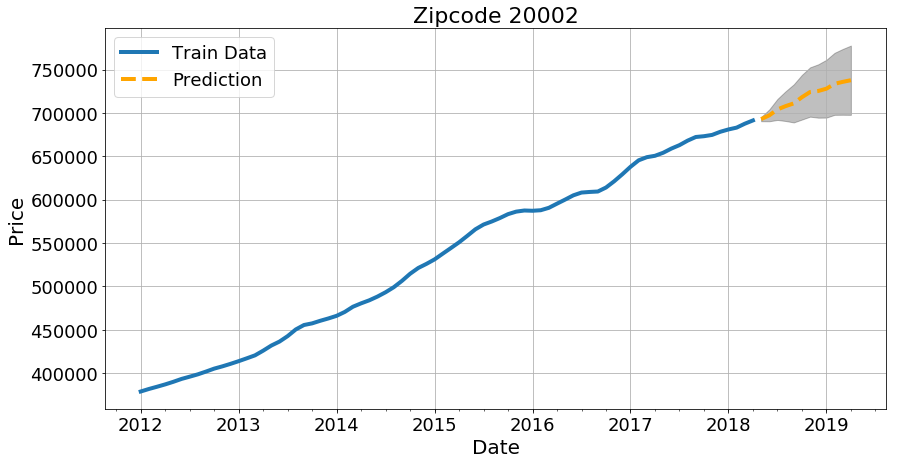

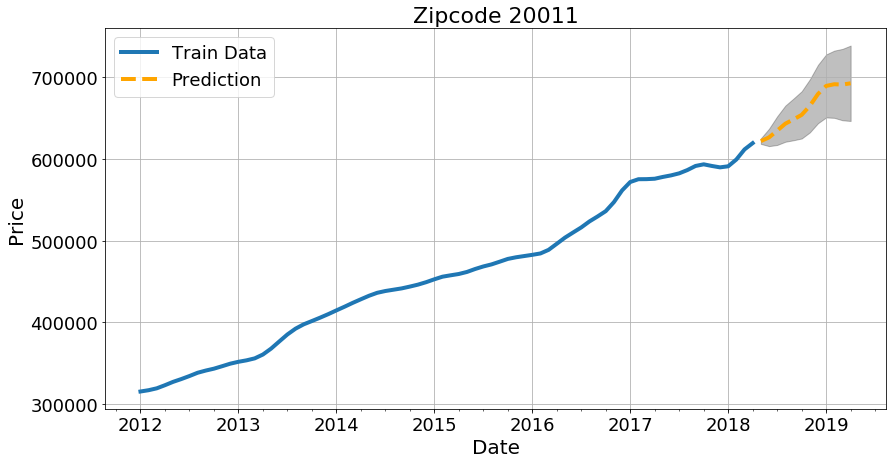

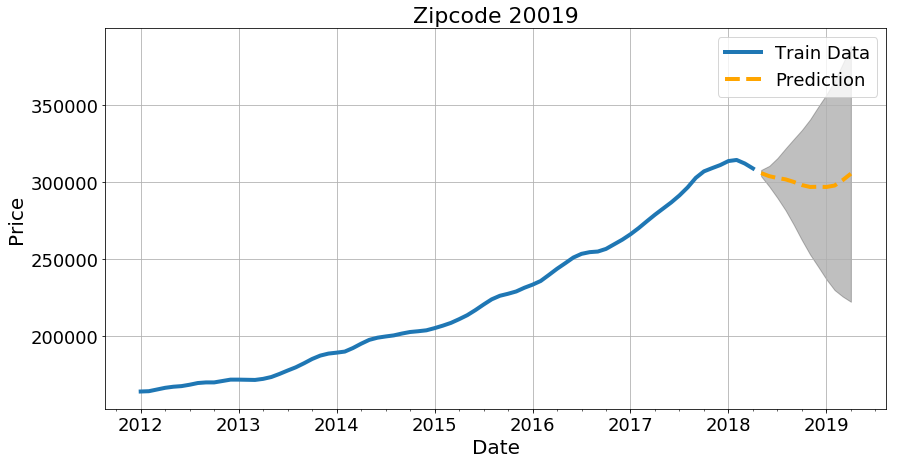

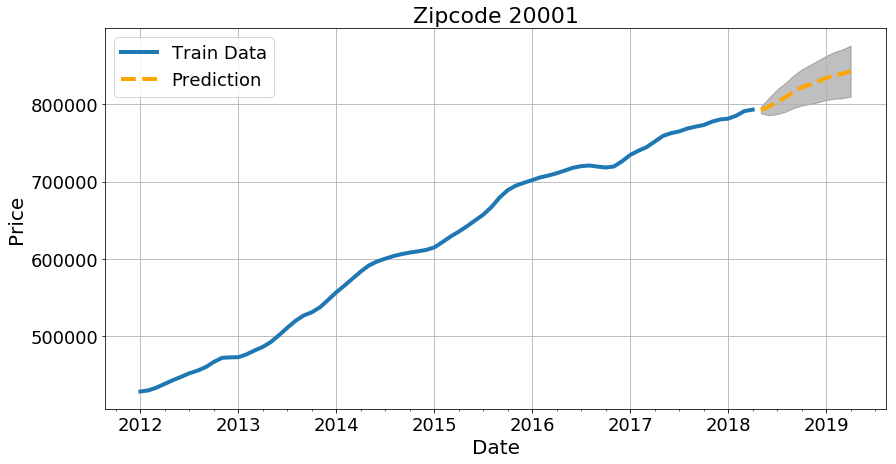

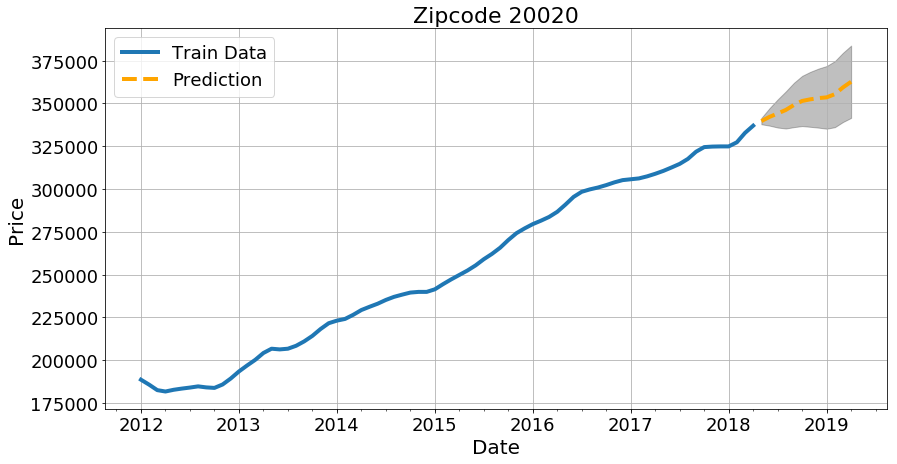

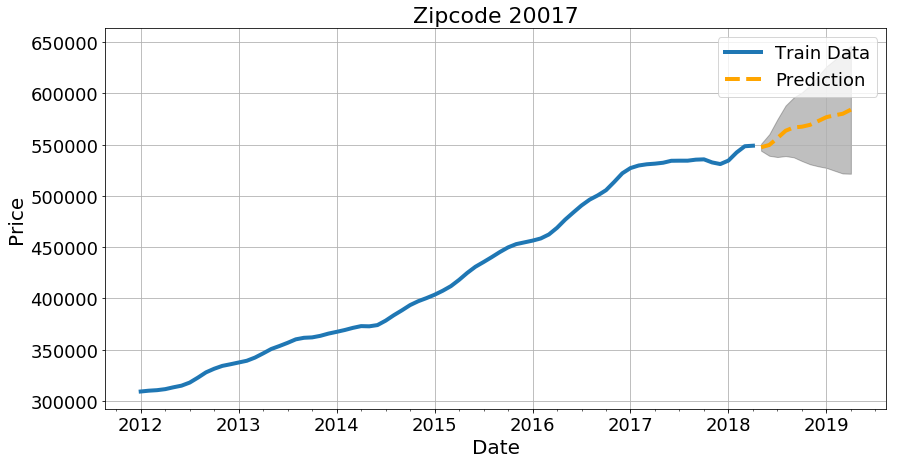

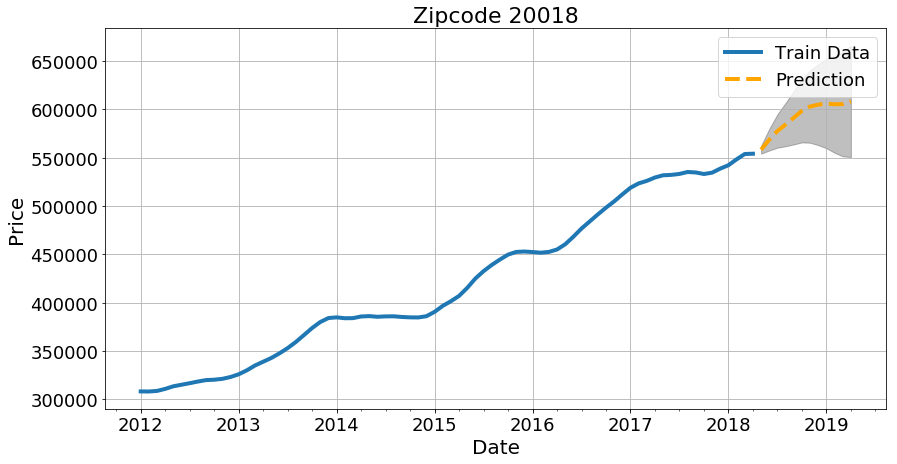

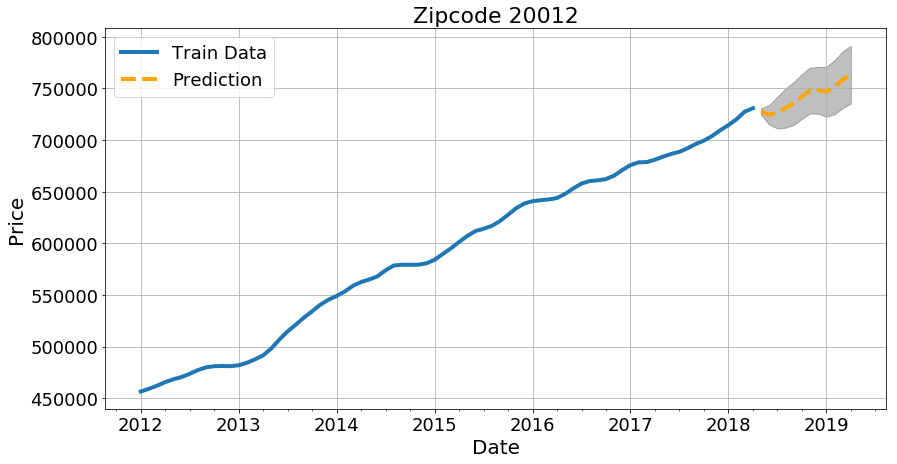

In [16]:
for i, val in enumerate(final_zipcodes):

    Make_PredictionPlot(final_results[i], final_train_data[i], 
                        final_test_data[i], val,time_cut, print_test=False)

In [17]:
profit = []
percent = []
profit_error = []

for model in final_results:
    pred = model.get_prediction(start=pd.to_datetime('2018-04'),
                              end=pd.to_datetime('2019-04'),
                             dynamic=True)
    pred_ci = pred.conf_int()
    
    error_A = (pred_ci.iloc[0,1] - pred_ci.iloc[0,0])/2
    error_B = (pred_ci.iloc[-1,1] - pred_ci.iloc[-1,0])/2
    error_profit = np.sqrt(error_A**2 + error_B**2)
    
    profit.append(pred.predicted_mean[-1] - pred.predicted_mean[0])
    percent.append(pred.predicted_mean[-1]/pred.predicted_mean[0]-1)
    profit_error.append(error_profit)

In [18]:
df_pred = pd.DataFrame({'zipcode':final_zipcodes,'profit':profit, 'percent': percent, "profit_error": profit_error}) 

In [19]:
df_pred['worst_case'] = df_pred['profit'] - df_pred['profit_error']
df_pred['best_case'] = df_pred['profit'] + df_pred['profit_error']


In [20]:
df_pred.sort_values(by='worst_case', ascending=False)

,zipcode,profit,percent,profit_error,worst_case,best_case
1,20011,77350.333047,0.124675,48361.169167,28989.163881,125711.502214
3,20001,53454.758240,0.067124,34673.414839,18781.343401,88128.173079
7,20012,34866.625523,0.047532,28783.292416,6083.333107,63649.917939
4,20020,28019.641083,0.082949,22403.732445,5615.908639,50423.373528
0,20002,44145.773162,0.063910,41850.426606,2295.346555,85996.199768
6,20018,62826.433958,0.112912,61025.010575,1801.423383,123851.444532
5,20017,45778.368096,0.083133,66999.607099,-21221.239003,112777.975195
2,20019,-2270.483121,-0.007356,90311.528511,-92582.011631,88041.045390
